In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy import signal

import sys
sys.path.insert(0,'..')
import specsens as ss

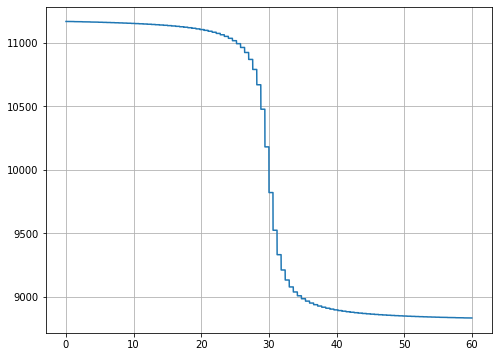

In [11]:
from scipy import constants


def get_relative_speed(t, l=1000.0, v=7660.0):
    # t -> time vector that starts by 0 and goes to whatever time you want (equally spaced)
    # l -> orthogonal distance of observer and object path in meters
    # v -> speed of object on its path in m/s

    # object -> thing that creates the signal (moving)
    # observer -> we / thing that receives the signal (stationary)

    # we will assume that the object will be closest to the oberserver at the half the time
    max_d = t[-1] * .5 * v

    # calculate objects position on its path at every time step
    x = max_d - t * v

    # calculate relative angle of observer and object at every time step
    # we will assume that the object is moving from right to left above the observer
    a = np.arctan2(x, l)

    # calculate realtive speed of object
    v = a / np.pi * 2. * v

    # calculate distance between object and observer
    d = np.sqrt(l**2. + x**2.)

    return v, d

def get_doppler(t, l=1000.0, v=7660.0, f0=450e5, f_sample=1e6, steps=1e3):
    
    # calculate relative speed and doppler shift using only 'steps' resultion
    t0 = np.linspace(0, int(t), steps, endpoint=False)
    v, d = get_relative_speed(t0, l, v)
    fd = v / constants.speed_of_light * f0
    
    # upscale to 't * f_sample' resolution
    t1 = np.linspace(0, int(t), int(t * f_sample), endpoint=False)
    fd = np.repeat(fd, int(t * f_sample / steps))

    return t1, fd

sample_freq = 1e5  # in Hz
length = 60.0  # in s
signal_strength = 0.0  # in dB
noise_strength = 0.0  # in dB

t, fc = get_doppler(t=length, # length of signal in seconds
                    l=10000.0, # distance in m
                    v=8000.0, # speed in m/s
                    f0=450e5, # acutal frequency of signal before down sapling to baseband
                    f_sample=sample_freq, # sample frequency after decimation
                    steps=100) # steps / resolution 

fc += 1e4 # add frequency offset in baseband

plt.figure(figsize=(8, 6))
plt.plot(t, fc)
plt.grid()
plt.show()

Signal power: 0.00 dB
Noise power:  -0.00 dB
SNR:          0.00 dB
Num Samples:  6000000 
Freq Energy:  719971376.72
Time Energy:  11999522.95


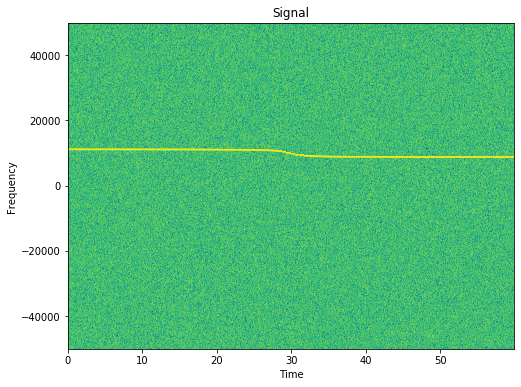

In [12]:
wm = ss.WirelessMicrophone(f_sample=sample_freq, t_sec=length)
sig = wm.get_very_silent(f_center=fc, power=signal_strength, dB=True)

wgn = ss.WhiteGaussianNoise(f_sample=sample_freq, t_sec=length)
noise = wgn.get_signal(power=noise_strength, dB=True)

assert wm.num_samples == wgn.num_samples  # ensure noise and signal have same length
num_samples = wm.num_samples

both = sig + noise  # create actual signal ('both') comprising of signal and additive white gaussian noise (AWGN)

print('Signal power: %.2f dB' % (ss.util.signal_power(sig, dB=True)))
print('Noise power:  %.2f dB' % (ss.util.signal_power(noise, dB=True)))
print('SNR:          %.2f dB' % (ss.util.snr(sig, noise, dB=True)))
print('Num Samples:  %d ' % (num_samples))

# Note, that Parseval's theorem holds
from scipy import fft
print("Freq Energy:  %.2f" % (np.sum(np.abs(fft.fft(both))**2)/sample_freq))
print("Time Energy:  %.2f" % (np.sum(np.abs(both)**2)))

sft = ss.Stft(n=1024, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
# plt.grid()
plt.show()

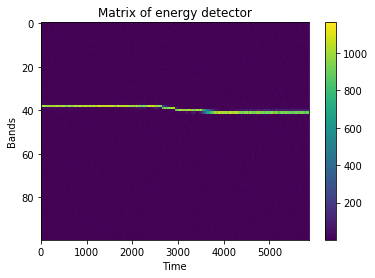

False Alarm: 0.00100
Threshold:   22.65737
Detection:   1.00000


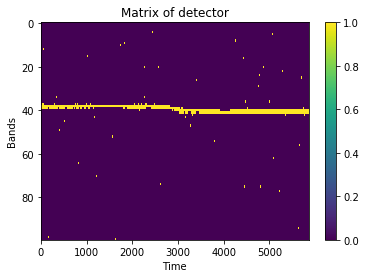

NameError: name 'mat' is not defined

In [13]:
# Use the STFT to transform the signal into the frequency domain
nfft = 1024

bands = 100

sft = ss.Stft(n=nfft, window='box')
f, t, x = sft.spectogram(both, sample_freq, normalized=False, dB=False)

# Create a Frequency Energy Detector object
fed = ss.FreqEnergyDetector(num_bands=bands,
                            f_sample=sample_freq,
                            fft_len=nfft,
                            freqs=f)

# Compute the energy at every timestep
res = []
for i in range(len(t)):
    res.append(fed.detect(x[:, i]))
res = np.array(res)

# Plot result of energy detector 
ss.util_wide.plot_matrix(res, title='energy detector')

# Compute threshold and probability of false alarm
pfa = 0.001
thr = ss.chi2_stats.get_thr(noise_power=noise_strength,
                            pfa=pfa,
                            n=nfft // bands,
                            dB=True)
pd = ss.chi2_stats.get_pd(noise_power=noise_strength,
                           signal_power=0.,
                           thr=thr,
                            n=nfft // bands,
                            dB=True,
                            bands=bands)
print('False Alarm: %.5f' % (pfa))
print('Threshold:   %.5f' % (thr))
print('Detection:   %.5f' % (pd))

# Apply threshold to result of energy detector matrix
res = (res > thr) * np.full_like(res, 1.)

ss.util_wide.plot_matrix(res, title='detector')

mats, factor = ss.util_wide.scale_matrix(mat, signal_length=1.024, band_width=1e4, fft_len=nfft)

print('Simulation False Alarm: %.5f' % (ss.util_wide.get_pfa(res, mats)))
print('Simulation Detection:   %.5f' % (ss.util_wide.get_pd(res, mats)))

In [ ]:
# Plot the spectogram our Short Time Fourier Transform
nfft = 1024

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(noise, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Noise")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(sig, sample_freq, normalized=True, dB=True)
plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Signal")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

sft = ss.Stft(n=nfft, window='flattop')
f, t, x = sft.spectogram(both, sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.pcolormesh(t,
               f,
               x,
               shading='flat',
               cmap='viridis',
               snap=True,
               vmin=np.min(x),
               vmax=np.max(x))
plt.title("Both")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Plot only 2nd FFT bin using our Short Time Fourier Transform

sft = ss.Stft(n=1024, window='flattop')
f, x = sft.stft(both[1024:2048], sample_freq, normalized=True, dB=True)

plt.figure(figsize=(8, 6))
plt.plot(f, x)
plt.title("Both")
plt.xlabel("Frequency")
plt.ylabel("Power level")
plt.show()

In [ ]:
# Use out 3D Plot 
ss.plot3d(sig=both,
          f_sample=sample_freq,
          window='flattop',
          nfft=1024,
          clip=-60,
          smooth=.5,
          crop=None,
          elev=30,
          azim=60,
          type='our')